# Para ejecutar en Google Colab en Drive

In [1]:
# Montamos el Drive al Notebook
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Verificamos el directorio en el que nos encontramos
!pwd
!ls

/content
drive  sample_data


In [3]:
# Cambiamos de directorio al Drive
import os
os.chdir("drive/My Drive/PruebasCOLAB2/path_prediction_variational")
!ls

background.npy		   linear_variational.py	       savefigure.py
base_variational_layer.py  Prueba_con_torch_variacional.ipynb  test_loo.py
lib			   rnn_variational.py		       training_loo.py


# Inicio de Código

In [17]:
# Imports
import sys,os
''' TF_CPP_MIN_LOG_LEVEL
0 = all messages are logged (default behavior)
1 = INFO messages are not printed
2 = INFO and WARNING messages are not printeds
3 = INFO, WARNING, and ERROR messages are not printed
'''
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
sys.path.append('lib/')
sys.path.append('lib/')
import math,numpy as np
import warnings
warnings.filterwarnings('ignore')

# Important imports
import matplotlib.pyplot as plt

from datasets_utils import setup_loo_experiment, get_testing_batch

In [18]:
import torch
torch.manual_seed(1)
# GPU
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))


NVIDIA GeForce GTX 1060


In [19]:
# Parameters
# The only datasets that can use add_social are those of ETH/UCY
# The only datasets that can use add_kp are PETS2009-S2L1, TOWN-CENTRE
class Experiment_Parameters:
    def __init__(self,add_social=False,add_kp=False,obstacles=False):
        # Maximum number of persons in a frame
        self.person_max =70
        # Observation length (trajlet size)
        self.obs_len    = 8
        # Prediction length
        self.pred_len   = 12
        # Flag to consider social interactions
        self.add_social = add_social
        # Number of key points
        self.kp_num     = 18
        # Key point flag
        self.add_kp     = add_kp
        # Obstacles flag
        self.obstacles    = obstacles
        self.intersection = False
        self.delim        = ','
        self.output_representation = 'dxdy' #

In [20]:
class Model_Parameters(object):
    """Model parameters.
    """
    def __init__(self, add_attention=True, add_kp=False, add_social=False, output_representation='dxdy'):
        # -----------------
        # Observation/prediction lengths
        self.obs_len        = 8
        self.pred_len       = 12
        self.seq_len        = self.obs_len + self.pred_len
        self.add_kp         = add_kp
        self.add_social     = add_social
        self.add_attention  = add_attention
        self.stack_rnn_size = 2
        self.output_representation = output_representation
        self.output_var_dirs= 0
        # Key points
        self.kp_size        = 18
        # Optical flow
        self.flow_size      = 64
        # For training
        self.num_epochs     = 35
        self.batch_size     = 256  # batch size 512
        self.use_validation = True
        # Network architecture
        self.P              =   2 # Dimensions of the position vectors
        self.enc_hidden_size= 256                  # Default value in NextP
        self.dec_hidden_size= self.enc_hidden_size # Default value in NextP
        self.emb_size       = 128  # Default value in NextP
        self.dropout_rate   = 0.3 # Default value in NextP

        #self.activation_func= tf.nn.tanh
        self.multi_decoder  = False
        self.modelname      = 'gphuctl'
        self.optimizer      = 'adam'
        self.initial_lr     = 0.01
        # MC dropout
        self.is_mc_dropout         = False
        self.mc_samples            = 20


In [21]:
# Load the default parameters
experiment_parameters = Experiment_Parameters(add_social=False,add_kp=False,obstacles=False)

dataset_dir   = "../datasets/"
dataset_names = ['eth-hotel','eth-univ','ucy-zara01','ucy-zara02','ucy-univ']
#dataset_names = ['eth-hotel','eth-univ','ucy-zara01']

In [22]:
# Load the dataset and perform the split
training_data, validation_data, test_data, test_homography = setup_loo_experiment('ETH_UCY',dataset_dir,dataset_names,2,experiment_parameters,use_pickled_data=False)

print('obs_traj: ',training_data['obs_traj'].shape)
print('obs_traj_rel: ',training_data['obs_traj_rel'].shape)
print('obs_traj_theta: ',training_data['obs_traj_theta'].shape)
print('pred_traj: ',training_data['pred_traj'].shape)
print('pred_traj_rel: ',training_data['pred_traj_rel'].shape)

[INF] Testing/validation dataset: ['ucy-zara01']
[INF] Training datasets: ['eth-hotel', 'eth-univ', 'ucy-zara02', 'ucy-univ']
[INF] Extracting data from the datasets
[INF] Sequence length (observation+prediction): 20
[INF] Reading ../datasets/ucy-zara01/mundo/mun_pos.csv
[INF] Total number of frames:  872
[INF] Total number of sample sequences:  2356
[INF] Sequence length (observation+prediction): 20
[INF] Reading ../datasets/eth-hotel/mundo/mun_pos.csv
[INF] Total number of frames:  1168
[INF] Reading ../datasets/eth-univ/mundo/mun_pos.csv
[INF] Total number of frames:  876
[INF] Reading ../datasets/ucy-zara02/mundo/mun_pos.csv
[INF] Total number of frames:  1052
[INF] Reading ../datasets/ucy-univ/mundo/mun_pos.csv
[INF] Total number of frames:  541
[INF] Total number of sample sequences:  17201
[INF] Training data: 15481
[INF] Test data: 2356
[INF] Validation data: 1720
obs_traj:  (15481, 8, 2)
obs_traj_rel:  (15481, 8, 2)
obs_traj_theta:  (15481, 8, 1)
pred_traj:  (15481, 12, 2)
pre

In [24]:
#############################################################
# Model parameters
model_parameters = Model_Parameters(add_attention=True,add_kp=experiment_parameters.add_kp,add_social=experiment_parameters.add_social,output_representation=experiment_parameters.output_representation)

model_parameters.num_epochs     = 40
model_parameters.output_var_dirs= 0
model_parameters.is_mc_dropout  = False # poner a False
model_parameters.initial_lr     = 0.03
model_parameters.dropout_rate   = 0


In [25]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms

# Creamos la clase para el dataset
class traj_dataset(Dataset):

    def __init__(self, Xrel_Train, Yrel_Train, X_Train, Y_Train, transform=None):
        self.Xrel_Train = Xrel_Train
        self.Yrel_Train = Yrel_Train
        self.X_Train = X_Train
        self.Y_Train = Y_Train
        self.transform = transform

    def __len__(self):
        return len(self.X_Train)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        xrel = self.Xrel_Train[idx]
        yrel = self.Yrel_Train[idx]
        x = self.X_Train[idx]
        y = self.Y_Train[idx]

        if self.transform:
            x = self.transform(x)
            y = self.transform(y)
            xrel = self.transform(xrel)
            yrel = self.transform(yrel)

        return xrel, yrel, x, y

In [26]:
# Creamos el dataset para torch
train_data = traj_dataset(training_data['obs_traj_rel'], training_data['pred_traj_rel'],training_data['obs_traj'], training_data['pred_traj'])
val_data = traj_dataset(validation_data['obs_traj_rel'], validation_data['pred_traj_rel'],validation_data['obs_traj'], validation_data['pred_traj'])
test_data = traj_dataset(test_data['obs_traj_rel'], test_data['pred_traj_rel'], test_data['obs_traj'], test_data['pred_traj'])

In [27]:
# Form batches
batched_train_data = torch.utils.data.DataLoader( train_data, batch_size = model_parameters.batch_size, shuffle=True)
batched_val_data =  torch.utils.data.DataLoader( val_data, batch_size = model_parameters.batch_size, shuffle=True)
batched_test_data =  torch.utils.data.DataLoader( test_data, batch_size = model_parameters.batch_size, shuffle=True)

In [28]:
import torch.nn as nn
import torch.nn.functional as F

from rnn_variational import *
from linear_variational import *

prior_mu = 0.0
prior_sigma = 1.0
posterior_mu_init = 0.0
posterior_rho_init = -4 #-3.0 # 0.006715348489117967 # 0.01814992791780978 # 0.04858735157374196

len_trainset = 15481
len_valset = 1720


class LSTM_variational(nn.Module):
    def __init__(self, in_size,  embedding_dim, hidden_dim, output_size):
        super(LSTM_variational, self).__init__()

        # Linear layer
        self.embedding = LinearReparameterization(
            in_features = in_size,
            out_features = embedding_dim, # 128
            prior_mean = prior_mu,
            prior_variance = prior_sigma,
            posterior_mu_init = posterior_mu_init,
            posterior_rho_init = posterior_rho_init,
        )

        # LSTM layer encoder
        self.lstm1 = LSTMReparameterization(
            in_features = embedding_dim,
            out_features = hidden_dim, # 256
            prior_mean = prior_mu,
            prior_variance = prior_sigma,
            posterior_mu_init = posterior_mu_init,
            posterior_rho_init = posterior_rho_init,
        )

        # LSTM layer decoder
        self.lstm2 = LSTMReparameterization(
            in_features = embedding_dim,
            out_features = hidden_dim, # 256
            prior_mean = prior_mu,
            prior_variance = prior_sigma,
            posterior_mu_init = posterior_mu_init,
            posterior_rho_init = posterior_rho_init,
        )
        # Linear layer
        self.decoder = LinearReparameterization(
            in_features = hidden_dim,
            out_features = output_size, # 12
            prior_mean = prior_mu,
            prior_variance = prior_sigma,
            posterior_mu_init = posterior_mu_init,
            posterior_rho_init = posterior_rho_init,
        )
        self.loss_fun = nn.MSELoss()

    def forward(self, X, y, training=False, num_mc=1):
      
        output_ = []
        kl_     = []
        # 
        nbatches = len(X)
        # Last position in the trajectory
        x_last = X[:,-1,:].view(nbatches, 1, -1) 

        # Monte Carlo iterations
        for mc_run in range(num_mc):
            kl_sum = 0
            # Layers
            emb, kl = self.embedding(X) # encoder for batch
            kl_sum += kl
            lstm_out, (hn1, cn1), kl = self.lstm1(emb)
            kl_sum += kl

            # Iterate for each time step
            pred = [] 
            for i, target in enumerate(y.permute(1,0,2)):
                emb_last, kl = self.embedding(x_last) # encoder for last position
                kl_sum += kl
                lstm_out, (hn2, cn2), kl = self.lstm2(emb_last, (hn1[:,-1,:],cn1[:,-1,:]))
                kl_sum += kl

                # Decoder and Prediction
                dec, kl = self.decoder(hn2)
                kl_sum += kl
                t_pred = dec + x_last
                pred.append(t_pred)

                # Update the last position
                if training:
                    x_last = target.view(len(target), 1, -1)
                    len_evaldataset = len_trainset
                else:
                    x_last = t_pred
                    len_evaldataset = len_valset
                hn1 = hn2
                cn1 = cn2

            # Concatenate the trajectories preds
            pred = torch.cat(pred, dim=1)

            # save to list
            output_.append(pred)
            kl_.append(kl_sum)

        pred = torch.mean(torch.stack(output_), dim=0)
        kl = torch.mean(torch.stack(kl_), dim=0)

        # Calculate of loss
        nll_loss = self.loss_fun(pred, y)

        #ELBO loss
        #loss = nll_loss + (kl / len_evaldataset)
        #loss = nll_loss + (kl / y.shape[0])
        loss = nll_loss
        # Concatenate the predictions and return
        return pred, loss

    def predict(self, X, dim_pred= 1):

      # Copy data
      x = X
      # Last position traj
      x_last = X[:,-1,:].view(len(x), 1, -1) 

      kl_sum = 0
      # Layers
      emb, kl = self.embedding(X) # encoder for batch
      kl_sum += kl
      lstm_out, (hn1, cn1), kl = self.lstm1(emb)
      kl_sum += kl

      # Iterate for each time step
      pred = [] 
      for i in range(dim_pred):
          emb_last, kl = self.embedding(x_last) # encoder for last position
          kl_sum += kl
          lstm_out, (hn2, cn2), kl = self.lstm2(emb_last, (hn1[:,-1,:],cn1[:,-1,:]))
          kl_sum += kl

          # Decoder and Prediction
          dec, kl = self.decoder(hn2)
          kl_sum += kl
          t_pred = dec + x_last
          pred.append(t_pred)

          # Update the last position
          x_last = t_pred
          hn1 = hn2
          cn1 = cn2

      # Concatenate the predictions and return
      return torch.cat(pred, dim=1).detach().cpu().numpy(), kl_sum
      

In [29]:
# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTM_variational(2,128,256,2)
model.to(device)

LSTM_variational(
  (embedding): LinearReparameterization()
  (lstm1): LSTMReparameterization(
    (ih): LinearReparameterization()
    (hh): LinearReparameterization()
  )
  (lstm2): LSTMReparameterization(
    (ih): LinearReparameterization()
    (hh): LinearReparameterization()
  )
  (decoder): LinearReparameterization()
  (loss_fun): MSELoss()
)

In [32]:
import torch.optim as optim

# Training the Model
optimizer = optim.SGD(model.parameters(), lr=model_parameters.initial_lr)

#optimizer = optim.SGD(model.parameters(), lr=0.015)
#optimizer = optim.SGD(model.parameters(), lr=0.03)
#optimizer = optim.SGD(model.parameters(), lr=0.05)
#optimizer = optim.SGD(model.parameters(), lr=0.08) #nan
#optimizer = optim.SGD(model.parameters(), lr=0.07) #nan 
#optimizer = optim.SGD(model.parameters(), lr=0.06) #nan 

epochs = model_parameters.num_epochs
num_mc = 5

for epoch in range(epochs):
    # Training
    print("----- ")
    print("epoch: ", epoch)
    error = 0
    total = 0
    for batch_idx, (data, target, _a , _b) in enumerate(batched_train_data):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        if torch.cuda.is_available():
            data  = data.to(device)
            target=target.to(device)

        # Step 2. Run our forward pass and compute the los
        pred, loss = model(data, target, training=True, num_mc=num_mc)

        #pred, loss = model(data, target)
        error += loss.detach().item()
        total += len(target)

        # Step 3. Compute the gradients, and update the parameters by
        loss.backward()
        optimizer.step()
    print("Training loss: {:.3e}".format(error/total))

    # Validation
    error = 0
    total = 0
    for batch_idx, (data_val, target_val, _ , _) in enumerate(batched_val_data):
        if torch.cuda.is_available():
            data_val  = data_val.to(device)
            target_val=target_val.to(device)
        pred_val, loss_val = model(data_val, target_val)
        error += loss_val.detach().item()
        total += len(target_val)

    print("Validation loss: {:.3e}".format(error/total))


----- 
epoch:  0
Training loss: 1.352e-05
Validation loss: 1.493e-04
----- 
epoch:  1
Training loss: 1.357e-05
Validation loss: 1.410e-04
----- 
epoch:  2
Training loss: 1.343e-05
Validation loss: 1.251e-04
----- 
epoch:  3
Training loss: 1.343e-05
Validation loss: 1.294e-04
----- 
epoch:  4
Training loss: 1.334e-05
Validation loss: 1.449e-04
----- 
epoch:  5
Training loss: 1.342e-05
Validation loss: 1.028e-04
----- 
epoch:  6
Training loss: 1.350e-05
Validation loss: 1.149e-04
----- 
epoch:  7
Training loss: 1.344e-05
Validation loss: 1.335e-04
----- 
epoch:  8
Training loss: 1.330e-05
Validation loss: 1.249e-04
----- 
epoch:  9
Training loss: 1.338e-05
Validation loss: 1.575e-04
----- 
epoch:  10
Training loss: 1.340e-05
Validation loss: 1.137e-04
----- 
epoch:  11
Training loss: 1.313e-05
Validation loss: 1.655e-04
----- 
epoch:  12
Training loss: 1.331e-05
Validation loss: 1.564e-04
----- 
epoch:  13
Training loss: 1.324e-05
Validation loss: 9.589e-05
----- 
epoch:  14
Training los

In [33]:
def plot_traj(pred_traj, obs_traj_gt, pred_traj_gt, test_homography, background):
    print("-----")
    homography = np.linalg.inv(test_homography)

    # Convert it to absolute (starting from the last observed position)
    displacement = np.cumsum(pred_traj, axis=0)
    this_pred_out_abs = displacement + np.array([obs_traj_gt[-1].numpy()])

    obs   = image_to_world_xy(obs_traj_gt, homography, flip=False)
    gt    = image_to_world_xy(pred_traj_gt, homography, flip=False)
    gt = np.concatenate([obs[-1,:].reshape((1,2)), gt],axis=0)
    tpred   = image_to_world_xy(this_pred_out_abs, homography, flip=False)
    tpred = np.concatenate([obs[-1,:].reshape((1,2)), tpred],axis=0)

    plt.figure(figsize=(12,12))
    plt.imshow(background)
    plt.plot(obs[:,0],obs[:,1],"-b", linewidth=2, label="Observations")
    plt.plot(gt[:,0], gt[:,1],"-r", linewidth=2, label="Ground truth")
    plt.plot(tpred[:,0],tpred[:,1],"-g", linewidth=2, label="Prediction")
    plt.legend()
    plt.title('Trajectory samples')
    plt.show()


-----
0


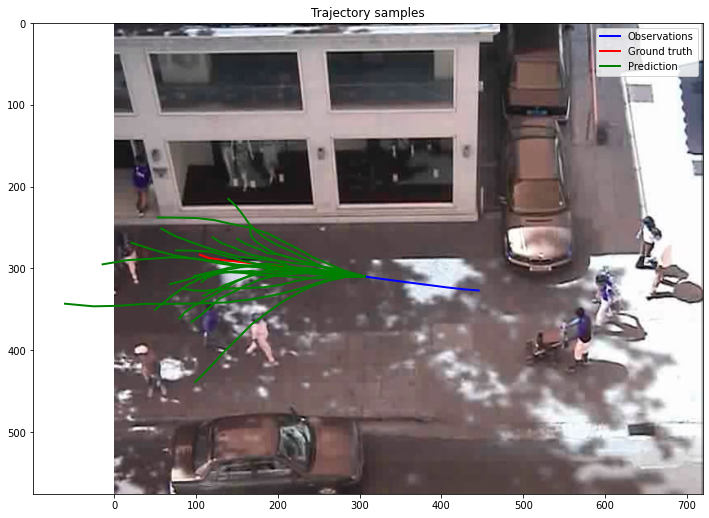

-----
1


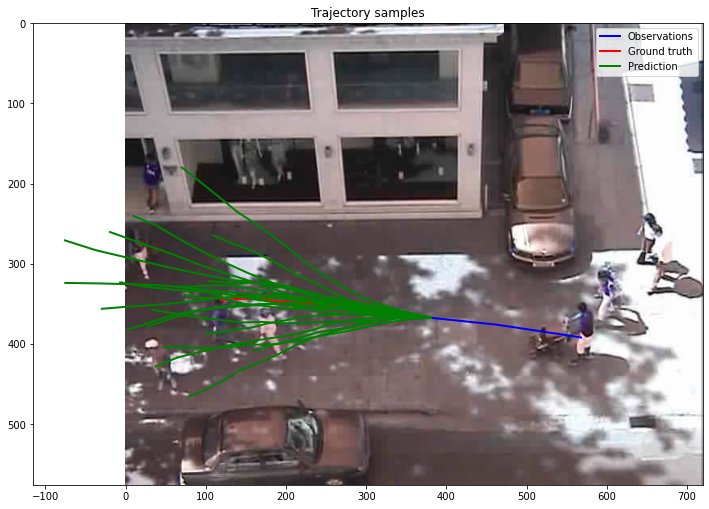

-----
2


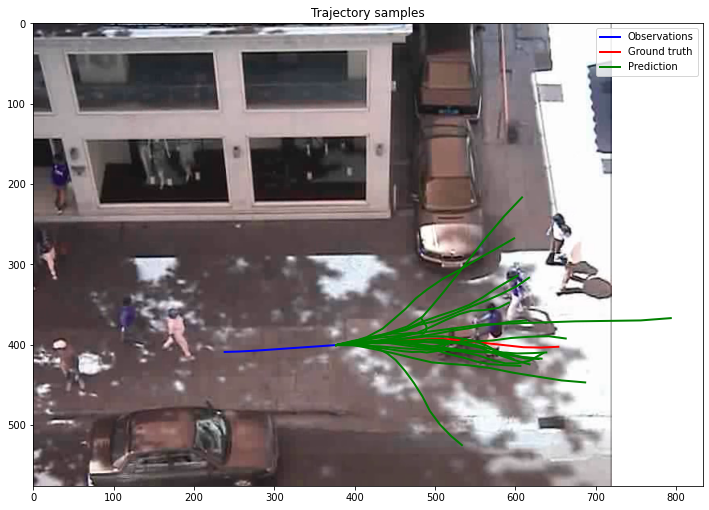

-----
3


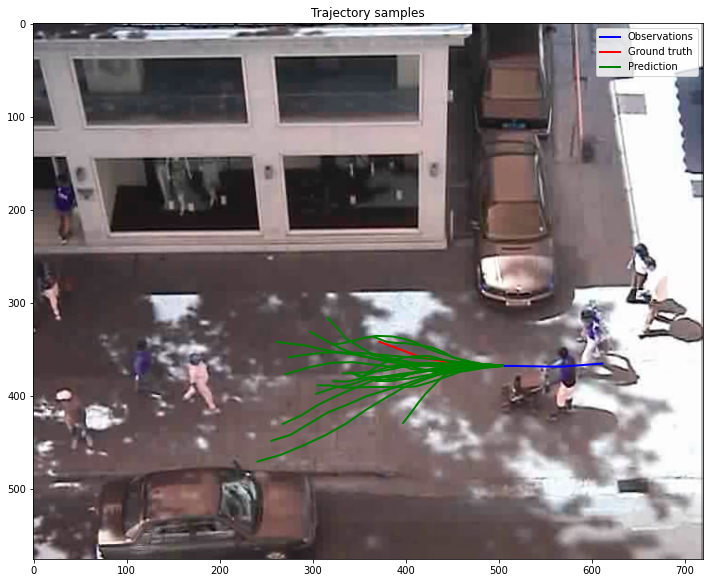

-----
4


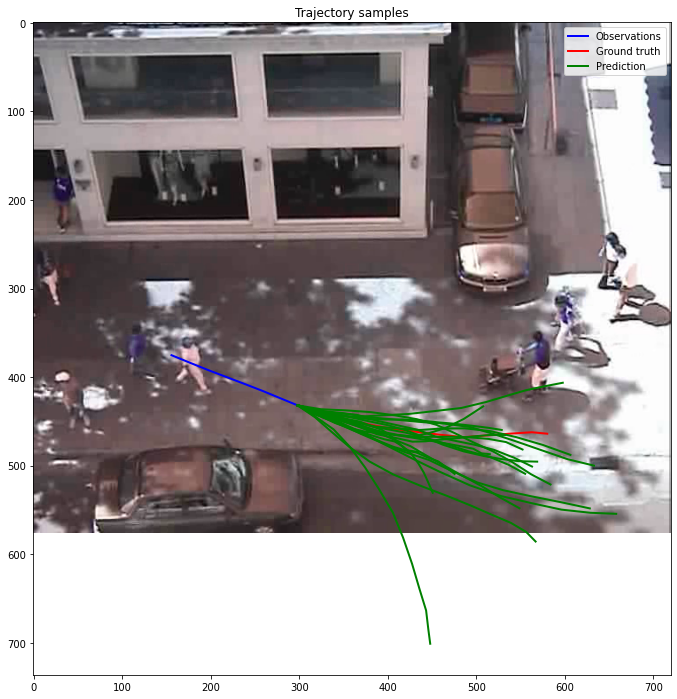

-----
5


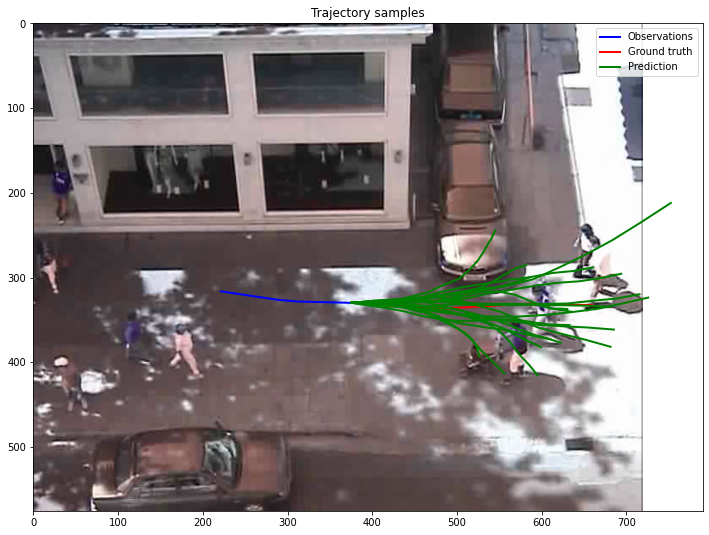

-----
6


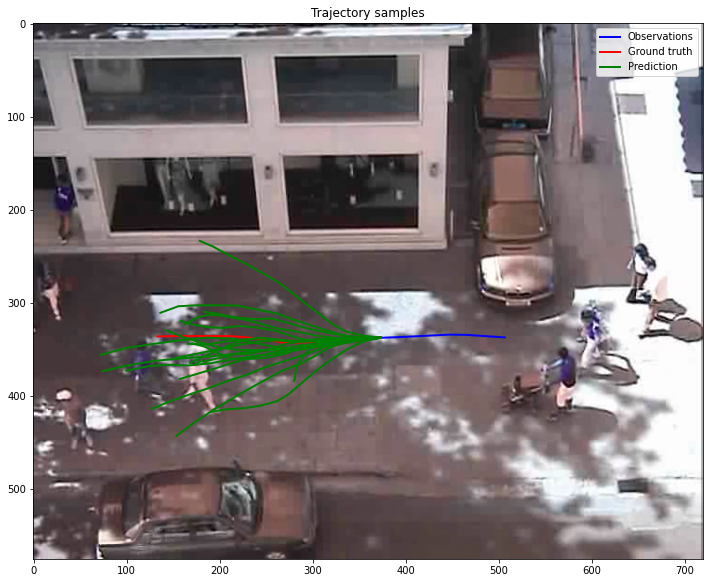

-----
7


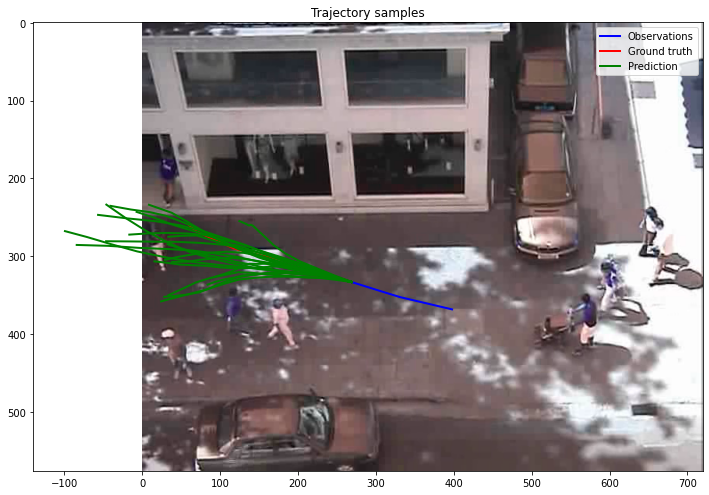

-----
8


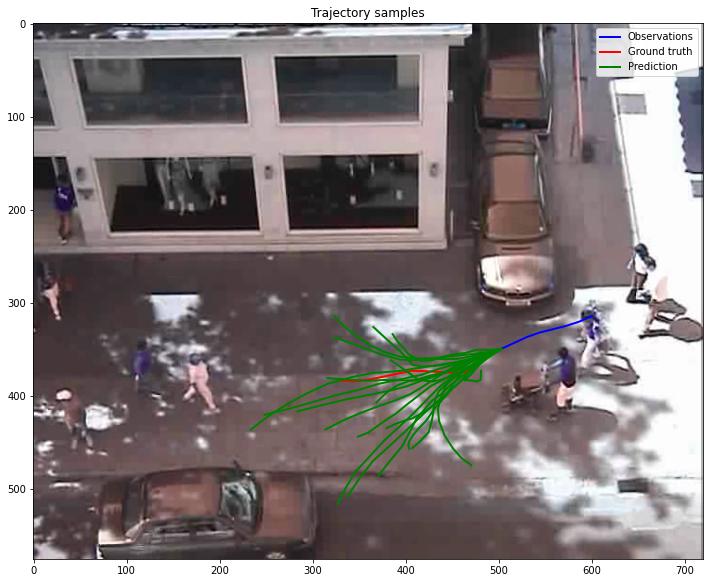

-----
9


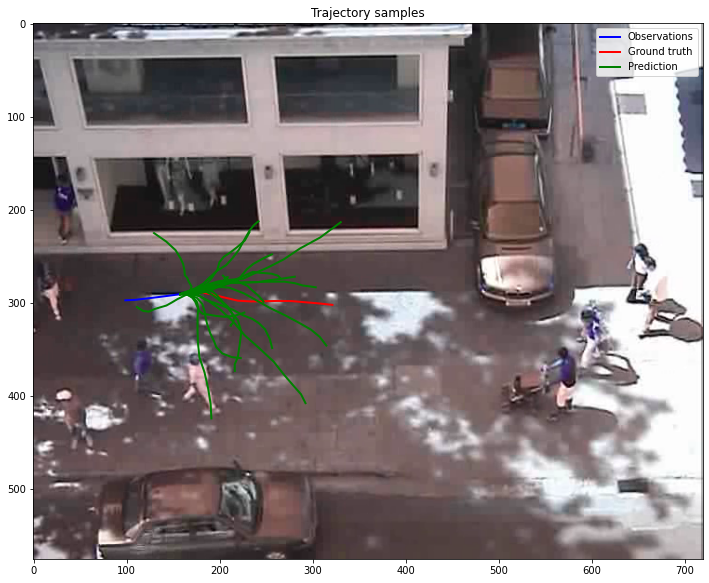

In [34]:
from obstacles import image_to_world_xy

num_samples = 30
num_monte_carlo = 20
i = 1 # sample of batch
bck = np.load('background.npy')

# Testing
cont = 0
for batch_idx, (datarel_test, targetrel_test, data_test, target_test) in enumerate(batched_test_data):
    print("-----")
    print(cont)
    if torch.cuda.is_available():
        datarel_test  = datarel_test.to(device)
        targetrel_test= targetrel_test.to(device)
        data_test     = data_test.to(device)
        target_test   = target_test.to(device)        
    homography = np.linalg.inv(test_homography)
    
    obs_traj_gt  = data_test[i,:,:]
    pred_traj_gt = target_test[i,:,:]
    obs   = image_to_world_xy(obs_traj_gt.cpu(), homography, flip=False)
    gt    = image_to_world_xy(pred_traj_gt.cpu(), homography, flip=False)
    gt = np.concatenate([obs[-1,:].reshape((1,2)), gt], axis=0)

    plt.figure(figsize=(12,12))
    plt.imshow(bck)
    plt.plot(obs[:,0],obs[:,1],"-b", linewidth=2, label="Observations")
    plt.plot(gt[:,0], gt[:,1],"-r", linewidth=2, label="Ground truth")

    # prediction
    for mc_run in range(num_monte_carlo):
        pred, kl = model.predict(datarel_test, dim_pred=12)
        # ploting 
        #plot_traj(pred[i,:,:], data_test[i,:,:], target_test[i,:,:], test_homography, bck)

        pred_traj = pred[i,:,:]

        # Convert it to absolute (starting from the last observed position)
        displacement      = np.cumsum(pred_traj, axis=0)
        this_pred_out_abs = displacement + np.array([obs_traj_gt[-1].cpu().numpy()])

        tpred = image_to_world_xy(this_pred_out_abs, homography, flip=False)
        tpred = np.concatenate([obs[-1,:].reshape((1,2)), tpred], axis=0)

        if mc_run == 0:
            plt.plot(tpred[:,0],tpred[:,1],"-g", linewidth=2, label="Prediction")
        else:
            plt.plot(tpred[:,0],tpred[:,1],"-g", linewidth=2)

    plt.legend()
    plt.title('Trajectory samples')
    plt.savefig("traj_variational_1_4"+str(cont)+".pdf")
    plt.show()

    cont += 1
        
    if cont == num_samples:
        break